{/* cspell:ignore POVM, mathbf, Filippov, Lindblad, Leahy, Rossi, García, Pérez  */}


# テンソルネットワークエラー緩和 (Tensor-network error mitigation, TEM): Algorithmiq による Qiskit Function

<Admonition type="note">
  Qiskit Functionsは、IBM Quantum™ Premium Plan ユーザーのみが利用できる実験的な機能です。プレビュー リリースの状態であり、変更される可能性があります。 
</Admonition>

## 概要
テンソルネットワーク エラー軽減 (TEM) 関数は、物理オザーバブルの推定においてノイズによるエラーを後処理することで、量子回路とオブザーバブルの期待値を計算します。

この方法は、量子プロセッサーの状態に影響を与えるグローバル ノイズ チャネルの逆を表すテンソル ネットワークを構築し、そのマップをノイズ状態から取得した情報的に完全な測定結果に適用することから構成されます。

TEMの利点としては、情報的に完全な測定を活用して、オブザーバブルの緩和された期待値の膨大なセットにアクセスでき、量子ハードウェア上で最適なサンプリングオーバーヘッドを持つことです\[1]。TEMは純粋に古典的なテンソルネットワーク法に関しても有利であり、古典的なテンソルネットワークアプローチよりも少ない計算コストで正確な結果を提供します。

詳細については参考文献\[1]を参照してください。

#### 参考文献

1.  S. Filippov, M. Leahy, M. A. C. Rossi, G. García-Pérez, Scalable tensor-network error mitigation for near-term quantum computing, [arXiv:1111.6950](https://arxiv.org/abs/2307.11740) \[quant-ph]


## 機能説明

TEM関数は、ノイズ層が特定されたノイズ回路を取り込みます。回路は情報的に完全な正の演算子値測定(informationally complete positive operator-valued measure, IC-POVM)で測定され、収集された測定結果は古典計算機上で処理されます。この測定結果を用いてテンソルネットワーク法を実行し、ノイズ反転マップ $\mathcal{N}^{-1}$ を構築します。このfunctionは、ノイズ層を表現する行列積演算子を用いて、ノイズ回路全体を完全に反転するマップ $\mathcal{M}$ を適用します。

![image.png](attachment:b530a99a-662c-43b1-a437-32a469de20d0.png "ノイズのある量子プロセッサーの測定結果を後処理することで、誤差を軽減したオブザーバブル Oの推定。U は理想的な量子演算、Nはそれに関連するノイズマップを表し、一般的に非局所的である（灰色のボックスまで拡張可能）。Dは、IC測定における効果に対応する演算子のテンソルを表す。ノイズ緩和モジュールMはテンソルネットワークで、途中から効率的に収縮される。収縮の最初の反復は紫の点線で、2回目は破線で、3回目は実線で表されている。")


ノイズを軽減するために、アルゴリズムは、中央（反転したノイズ回路が終了し、理想回路が開始するところ）から開始し、各反復で左側の2層と右側の1層を巻き込んで外側に伝播する収縮を行う。従って、したがって、ノイズのある回路の出力状態$\rho$は$(\vert 0 \rangle\langle0\vert)^{\otimes N}$に戻され、これが理想的なノイズのない状態演算子$\vert\psi\rangle\langle \psi\vert$にマッピングされます。

したがって、オブザーバブル ${O}$ のノイズの緩和された推定は次のように読めます。
$$
\bar{O}_{\text{n}.\text{m}} = \frac{1}{S} \sum_{\mathbf{k}} \text{tr} [\mathcal{M}(D_{\mathbf{k}})O] = \frac{1}{S} \sum_{\mathbf{k}} \text{tr} [D_{\mathbf{k}}\mathcal{M}^{\dagger}(O)],$$


ここで $D\mathbf{k}$ は、$S$ ショットのセット内の測定ショット $\mathbf{k}$ に関連付けられた対応するPOVMのdual演算子です。

このアルゴリズムについては[Filippov et al. (2023)](https://arxiv.org/abs/2307.11740) でさらに詳しく説明されています。

### 方法

#### run

`run(pubs,options)`

run() メソッドを使用すると、回路とオブザーバブルのリストを含むprimitive unified bloc (PUB) の期待値を計算できます。

**Parameters**

Name | Type | Description | Required | Example
-- | -- | -- | -- | --
pubs | Iterable\[EstimatorPubLike] | An iterable of PUB-like (primitive unified bloc) objects, such as tuples `(circuit, observables)` or `(circuit, observables, parameter_values)`. See [Overview of PUBs](/guides/primitive-input-output#overview-of-pubs) for more information. The circuits don’t need to be ISA circuits. | Yes | (circuit, observables, parameter\_values)
instance | str | The hub/group/project to use in that format. | No | "hub1/group1/project1"
options | dict | Input options. See `Options` section for more details. | No | \{"optimization\_level": 3}

**Options**

TEM のオプションを含む辞書。辞書には次のキーが含まれている必要があります:

Name | Type | Description  | Example
-- | -- | -- | --
backend\_name | str | Name of the backend to make the query.| "ibm\_fez"
simulate\_with\_noise\_model | bool | A Boolean flag indicating whether to simulate the noisy circuit or not.| False
max\_bond\_dimension | int | The maximum bond dimension to be used for MPOs. | True
tem\_compression\_cutoff | float | The cutoff value to be used for MPOs. | 1e-16
num\_max\_shots | int | The maximum number of shots. | 10\_000
num\_randomizations | int | The number of randomizations to be used for gate twirling. | 32
mitigate\_readout\_error | bool | A Boolean flag indicating whether to perform QDT readout error mitigation or not. | 24
num\_readout\_calibration\_shots | int | The number of shots to be used for QDT readout error mitigation. | 1000
logging\_level | str | The logging level to be used for the TEM runner. | "INFO"

**Returns**

TEM 緩和結果を含む PubResult:

Name |Type | Description
-- | -- | --
data | DataBin | A DataBin containing the TEM mitigated observable and its standard error. The DataBin has the following fields: <ul><li>`observable`: The TEM mitigated observable value.</li><li>`observable_stderr`: The standard error of the TEM mitigated observable.</li></ul>
metadadata | dict | A dictionary containing additional results. The dictionary contains the following keys: <ul><li>`"observable_non_mitigated"`: The observable value without error mitigation.</li><li>`"observable_non_mitigated_stderr"`: The standard error of the result without error mitigation.</li><li>`"observable_simulated"`: If its computation is enabled in the TEM options, contains the result obtained by simulating the circuit with the learned noise.</li></ul>

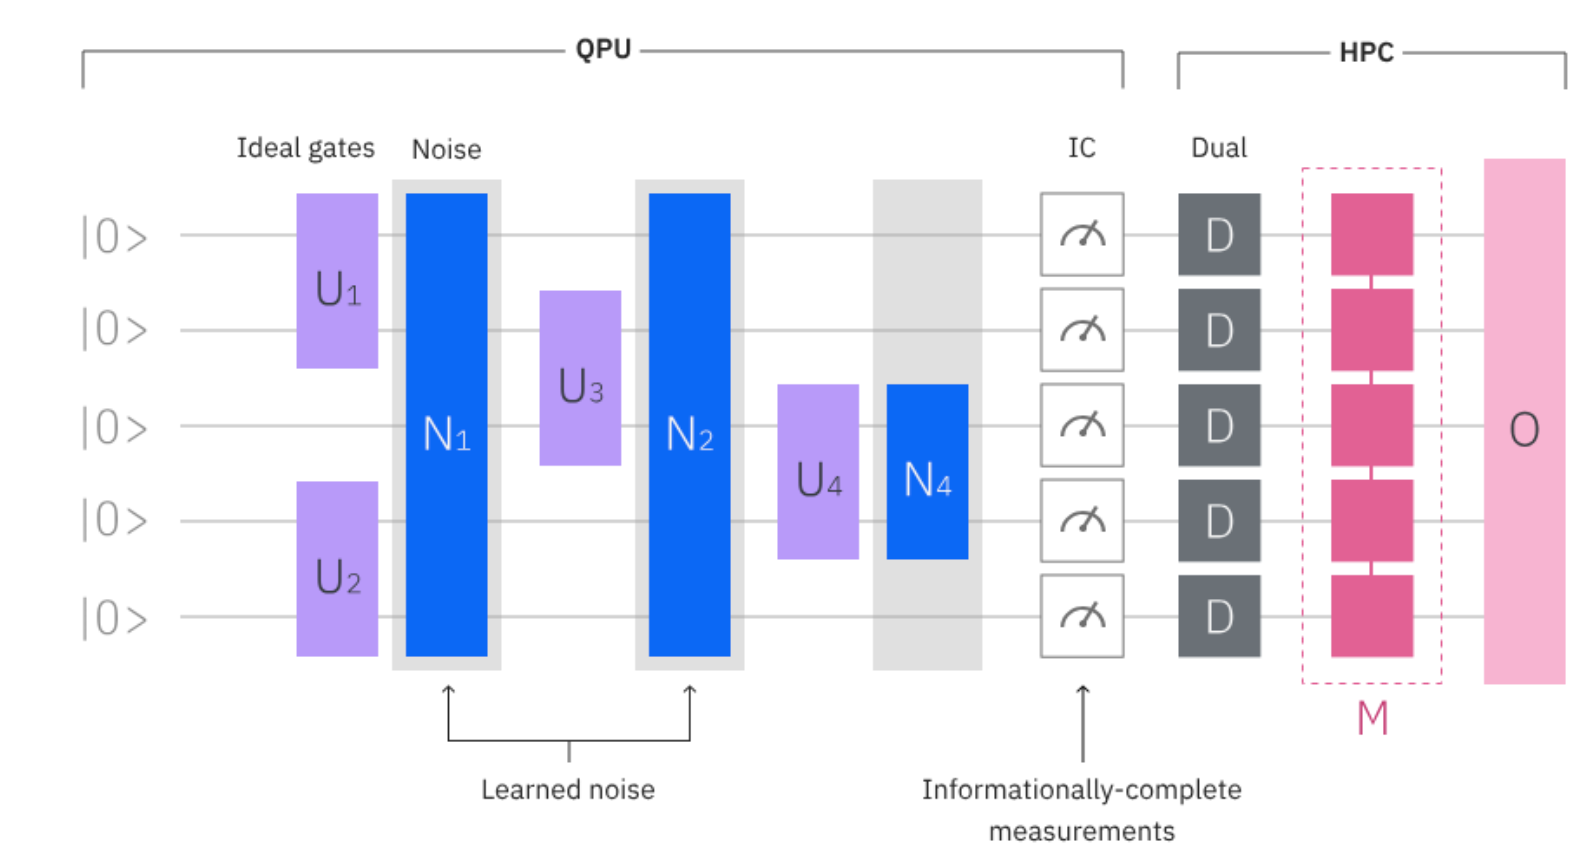

## 始めてみましょう

[IBM Quantum Platform API token](http://quantum.ibm.com/)を使用して認証し、次のように TEM を選択します：

In [1]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

tem_function_name = "algorithmiq/tem"
catalog = QiskitFunctionsCatalog(token = "<YOUR_IQP_API_TOKEN>")

# Load your function
tem = catalog.load(tem_function_name)

## Example

次のコードは、シンプルな量子回路を与えられオブザーバブルの期待値を計算するのに TEM が使用される例を示しています。


In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService

# Create a quantum circuit
qc = QuantumCircuit(3)
qc.u(0.4, 0.9, -0.3, 0)
qc.u(-0.4, 0.2, 1.3, 1)
qc.u(-1.2, -1.2, 0.3, 2)
for _ in range(2):
    qc.barrier()
    qc.cx(0, 1)
    qc.cx(2, 1)
    qc.barrier()
    qc.u(0.4, 0.9, -0.3, 0)
    qc.u(-0.4, 0.2, 1.3, 1)
    qc.u(-1.2, -1.2, 0.3, 2)

# Define the observables
observable = SparsePauliOp("YXZ", 1.0)

# Define the execution options
service = QiskitRuntimeService()
backend_name = service.least_busy(operational=True).name
instance = "<IQP_HUB/IQP_GROUP/IQP_PROJECT>"

pub = (qc, observable)
options = {
    "backend_name": backend_name,
    "num_max_shots": 100,
}
job = tem.run(instance=instance, pub=pub, options=options)

次のコードは、単純な量子回路を与えられオブザーバブルの期待値を計算するのに TEM が使用される例を示しています。

In [ ]:
print(job.status())
result = job.result()

## Advanced options
TEM に追加のオプションを渡すことで、計算を微調整し、より詳細な情報を取得できます。


In [7]:
import logging

options = {
        "backend_name": backend_name,
        "num_max_shots": 1_000,
        "simulate_with_noise_model": True,
        "mitigate_readout_error": True,
        "num_readout_calibration_shots": 10_000,
        "logging_level": logging.WARNING
    }


job = tem.run(instance = instance, pub = pub, options = options)

## サポートを受ける

[qiskit\_ibm@algorithmiq.fi](mailto:qiskit_ibm@algorithmiq.fi) に連絡し、次の情報を伝えてください。


*   Qiskit Function Job ID (`qiskit-ibm-catalog`), `job.job_id`

*   問題の詳細な説明

*   関連するエラーメッセージまたはコード

*   問題を再現する手順


## 次のステップ

<Admonition type="tip" title="Recommendations">
  *   [Algorithmiq Tensor-network error mitigation へのアクセスをリクエストする](https://quantum.ibm.com/functions?id=4b1b9d76-c18b-4788-b70b-15125111fbe6)
</Admonition>
